# D5 fat inflation

In [2]:
import sympy
sympy.init_printing()

import numpy as np
from einsteinpy.symbolic import MetricTensor
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

#import inflatox
import inflatox

In [7]:
gs, ls, N = sympy.symbols('g_s l_s N')
mu5, T5, Lt = sympy.symbols('mu5 T5 L_T')

mu5 = (2 * sympy.pi)**5 * ls**6
T5 = mu5 / gs
Lt = ((27 / 4) * sympy.pi * N * gs * ls**4).nsimplify()

display(T5, mu5, Lt)

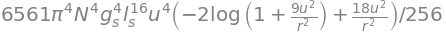

In [14]:
r, u = sympy.symbols('r, u')
rho, theta = sympy.symbols('rho theta')
rho = r / (3*u)

H = (Lt / 3*u)**4 * (2 / rho**2 - 2*sympy.ln(1/rho**2 +1))
display(rho, H)

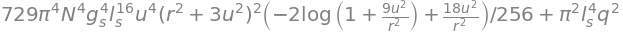

In [15]:
p, q = sympy.symbols('p q')

F = H / 9 * (r**2 + 3*u**2)**2 + (sympy.pi*q*ls**2)**2
gamma = 4*sympy.pi**2*ls**2*p*q*T5*gs
display(F, gamma)

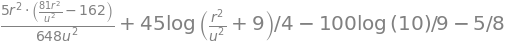

In [16]:
Phi_min, Phi_h = sympy.symbols('Phi_- Phi_h')
Phi_min = ( (5/72) * (
  81*(9*rho**2 - 2)*rho**2 +
  162*sympy.ln(9*(rho**2 + 1)) +
  -9 +
  -160*sympy.ln(10)
)).nsimplify()
display(Phi_min)

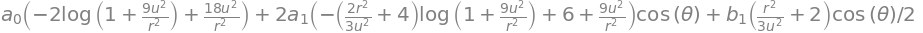

In [17]:
a0, a1, b1 = sympy.symbols('a0 a1 b1')
Phi_h = (a0 * (2/rho**2 -2*sympy.ln(1/rho**2 + 1))
  + 2*a1*(
    6 + 1/rho**2 -2*(2+3*rho**2)*sympy.ln(1 + 1/rho**2)
  )*sympy.cos(theta)
  + (b1/2) * (2+3*rho**2)*sympy.cos(theta)
)
display(Phi_h)